In [42]:
# Uncomment and run to install packages if needed.
#install.packages("fpp3")
#install.packages("urca")
#install.packages("gridExtra")
install.packages("forecast")

# Load necessary libraries
suppressPackageStartupMessages({
  suppressWarnings({
    library(fpp3) # for time series models (ARIMA, ETS, TSLM, etc.)
    library(ggplot2) # for visualization
    library(dplyr)
    library(tsibble)
    library(fable)
    library(gridExtra)
    library(ggplot2)
    library(fabletools)
  })
})

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘quantmod’, ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘zoo’, ‘RcppArmadillo’




In [3]:
# Load and prepare the dataset
nsw_data <- read.csv("combine.csv", header = FALSE,
                     col.names = c("Region", "Date", "MaxDemand", "RRP", "PeriodType"))
nsw_data <- nsw_data[, c("Date", "MaxDemand")]

In [4]:
# Inspect structure
glimpse(nsw_data)

Rows: 192,673
Columns: 2
$ Date      <chr> "SETTLEMENTDATE", "2024/01/01 00:05:00", "2024/01/01 00:10:0…
$ MaxDemand <chr> "TOTALDEMAND", "6574.92", "6651.09", "6538.96", "6497.99", "…


In [5]:
nsw_data <- nsw_data %>%
  as_tibble() %>%
  mutate(
    Date = as.Date(Date, format = "%Y/%m/%d"),
    MaxDemand = as.numeric(MaxDemand)  # Convert to numeric
  ) %>%
  filter(!is.na(Date) & !is.na(MaxDemand)) %>%  # Remove rows with NA dates or demand
  group_by(Date) %>%
  summarise(MaxDemand = max(MaxDemand, na.rm = TRUE)) %>%
  ungroup() %>%
  as_tsibble(index = Date)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `MaxDemand = as.numeric(MaxDemand)`.
Caused by warning:
! NAs introduced by coercion”


In [6]:
nsw_data <- nsw_data %>%
  as_tsibble(index = Date)

In [7]:
train_data <- nsw_data %>%
  filter(Date < as.Date("2025-10-01")) %>%
  filter(!is.na(MaxDemand))

test_data <- nsw_data %>%
  filter(Date >= as.Date("2025-10-01")) %>%
  filter(!is.na(MaxDemand))

In [8]:
# Split into Training and Testing sets
# Training: all data up to September 2025, Testing: October 2025
train_data <- nsw_data %>% filter(Date < as.Date("2025-10-01"))
test_data <- nsw_data %>% filter(Date >= as.Date("2025-10-01"))


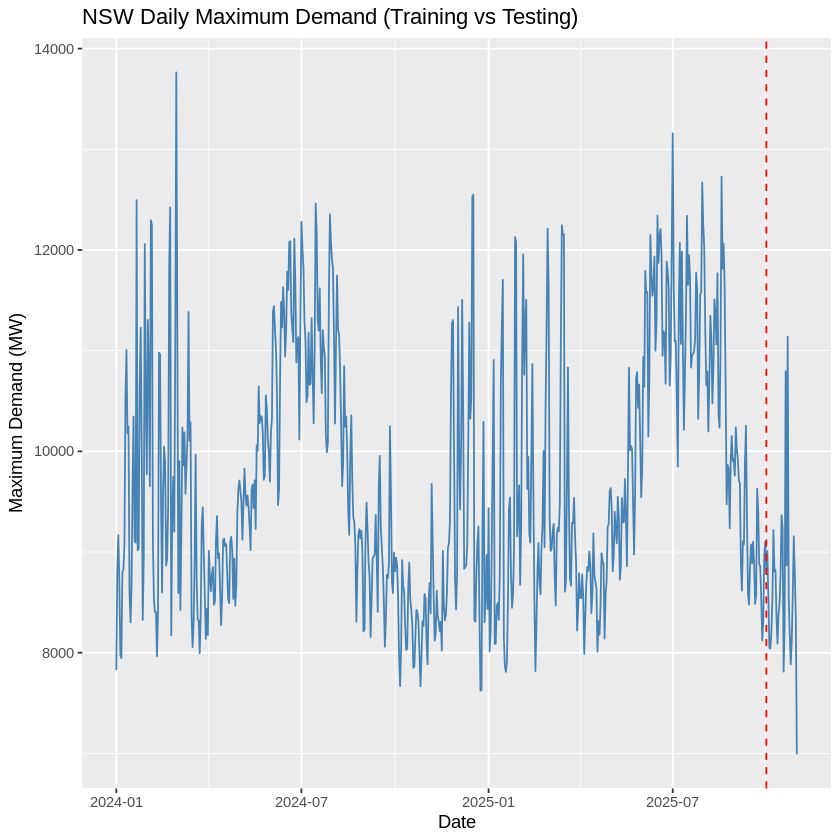

In [9]:
# Visualize the split
nsw_data %>%
  ggplot(aes(x = Date, y = MaxDemand)) +
  geom_line(color = "steelblue") +
  geom_vline(xintercept = as.Date("2025-10-01"),
             linetype = "dashed", color = "red") +
  labs(title = "NSW Daily Maximum Demand (Training vs Testing)",
       y = "Maximum Demand (MW)", x = "Date")

Series: MaxDemand 
Model: ARIMA(0,1,1)(0,1,1)[7] 

Coefficients:
          ma1     sma1
      -0.1880  -1.0000
s.e.   0.0773   0.0233

sigma^2 estimated as 574261:  log likelihood=-5093.95
AIC=10193.91   AICc=10193.95   BIC=10207.25


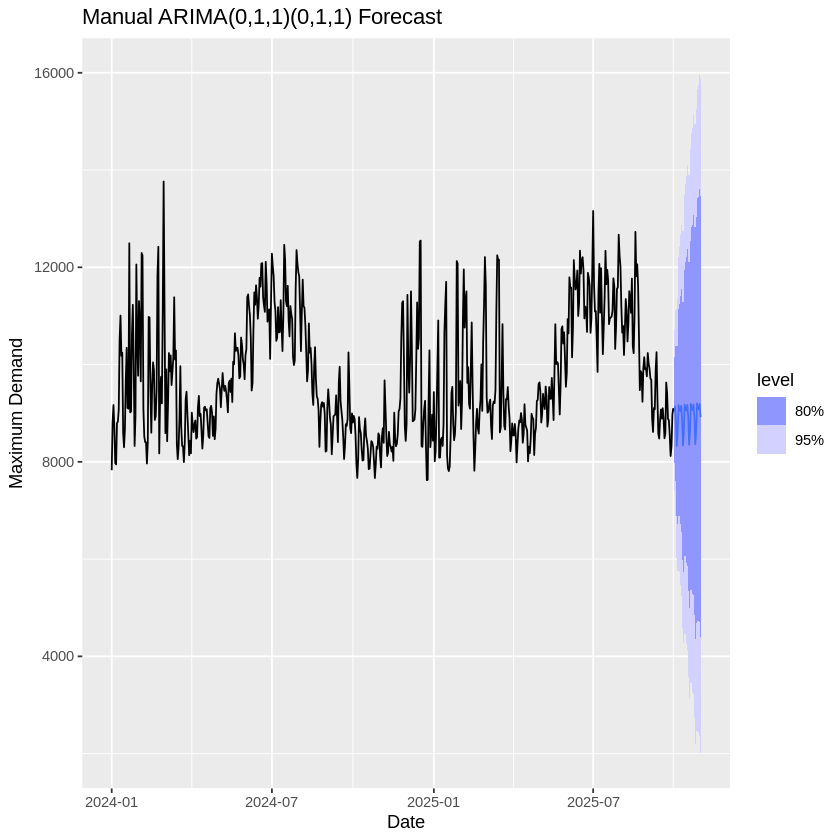

In [10]:
# Fit Manual ARIMA Model
  manual_arima <- train_data %>%
  model(ARIMA(MaxDemand ~ pdq(0,1,1) + PDQ(0,1,1)))

report(manual_arima)

# Forecast on test data
manual_forecast <- forecast(manual_arima, h = nrow(test_data))

# Plot manual ARIMA results
autoplot(manual_forecast, train_data) +
  labs(title = "Manual ARIMA(0,1,1)(0,1,1) Forecast",
       y = "Maximum Demand", x = "Date")


Series: MaxDemand 
Model: ARIMA(1,1,2)(0,0,2)[7] 

Coefficients:
         ar1      ma1      ma2    sma1    sma2
      0.2107  -0.4296  -0.4167  0.1310  0.1871
s.e.  0.0721   0.0656   0.0489  0.0402  0.0402

sigma^2 estimated as 503428:  log likelihood=-5091.67
AIC=10195.35   AICc=10195.48   BIC=10222.1


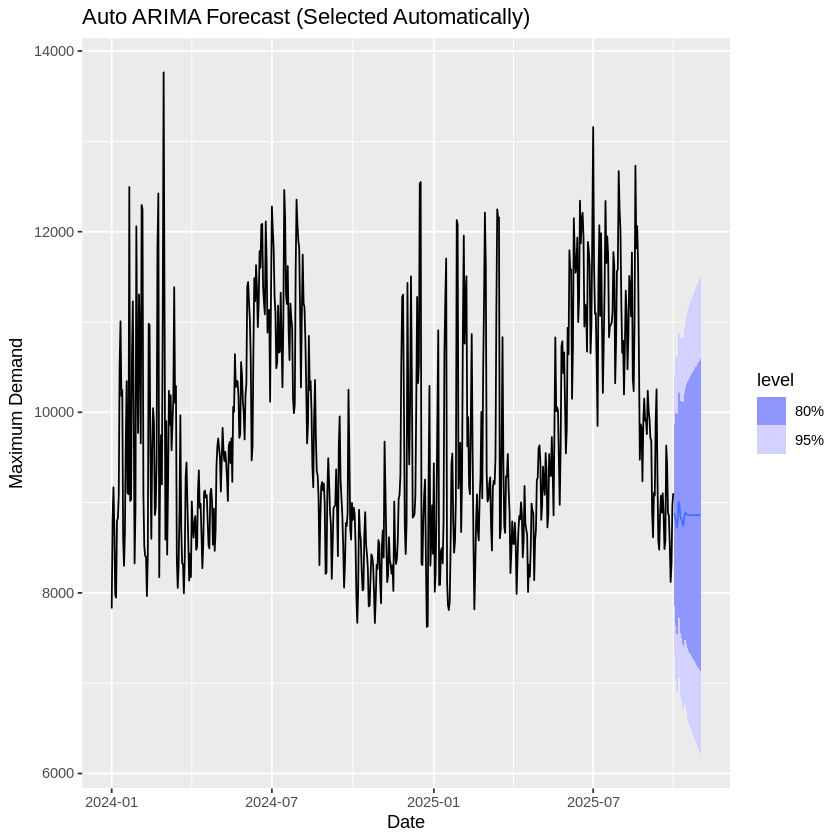

In [11]:
# Fit Auto ARIMA Model
auto_arima <- train_data %>%
  model(ARIMA(MaxDemand))

report(auto_arima)

# Forecast on test data
auto_forecast <- forecast(auto_arima, h = nrow(test_data))

# Plot auto ARIMA results
autoplot(auto_forecast, train_data) +
  labs(title = "Auto ARIMA Forecast (Selected Automatically)",
       y = "Maximum Demand", x = "Date")


In [12]:
# Compare Results

# Combine forecasts for comparison
accuracy_results <- bind_rows(
  accuracy(manual_forecast, test_data),
  accuracy(auto_forecast, test_data),
  .id = "Model"
)

accuracy_results

Model,.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"ARIMA(MaxDemand ~ pdq(0, 1, 1) + PDQ(0, 1, 1))",Test,-267.3521,741.9146,554.8150,-3.723085,6.424959,NaN,NaN,0.07301251
2,ARIMA(MaxDemand),Test,-198.4321,800.2648,583.5513,-3.051071,6.754740,NaN,NaN,0.13823531


In [13]:
# Fit Manual ETS Model
print(train_data)
summary(train_data$MaxDemand)
has_gaps(train_data)


# A tsibble: 639 x 2 [1D]
   Date       MaxDemand
   <date>         <dbl>
 1 2024-01-01     7828.
 2 2024-01-02     8811.
 3 2024-01-03     9168.
 4 2024-01-04     8711.
 5 2024-01-05     7974.
 6 2024-01-06     7948.
 7 2024-01-07     8800.
 8 2024-01-08     8825.
 9 2024-01-09     9076.
10 2024-01-10    10523.
# ℹ 629 more rows


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   7623    8749    9444    9750   10779   13764 

.gaps
<lgl>
FALSE


Series: MaxDemand 
Model: ETS(M,A,M) 
  Smoothing parameters:
    alpha = 0.5848713 
    beta  = 0.005340058 
    gamma = 0.0449898 

  Initial states:
     l[0]     b[0]     s[0]     s[-1]     s[-2]    s[-3]     s[-4]    s[-5]
 8601.718 155.5825 1.047225 0.9217148 0.9793855 1.006739 0.9741256 1.036788
    s[-6]
 1.034023

  sigma^2:  0.006

     AIC     AICc      BIC 
12606.67 12607.17 12660.19 


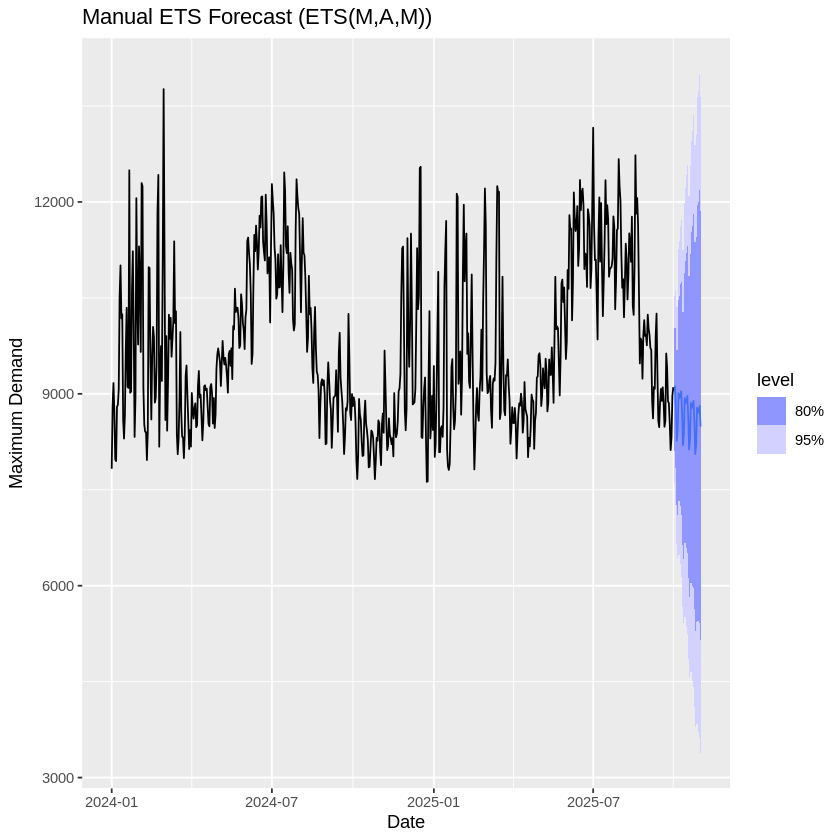

In [14]:
# Fit Manual ETS Model

ets_manual <- train_data %>%
  model(ETS(MaxDemand ~ error("M") + trend("A") + season("M")))

report(ets_manual)

ets_manual_fc <- forecast(ets_manual, h = nrow(test_data))

autoplot(ets_manual_fc, train_data) +
  labs(
    title = "Manual ETS Forecast (ETS(M,A,M))",
    y = "Maximum Demand", x = "Date"
  )

Series: MaxDemand 
Model: ETS(M,Ad,M) 
  Smoothing parameters:
    alpha = 0.9685772 
    beta  = 0.0001000675 
    gamma = 0.0001001072 
    phi   = 0.9776881 

  Initial states:
     l[0]     b[0]      s[0]     s[-1]     s[-2]    s[-3]    s[-4]    s[-5]
 8130.745 174.5486 0.9680079 0.9403061 0.9975744 1.029043 1.018577 1.017628
    s[-6]
 1.028864

  sigma^2:  0.0053

     AIC     AICc      BIC 
12523.74 12524.32 12581.72 


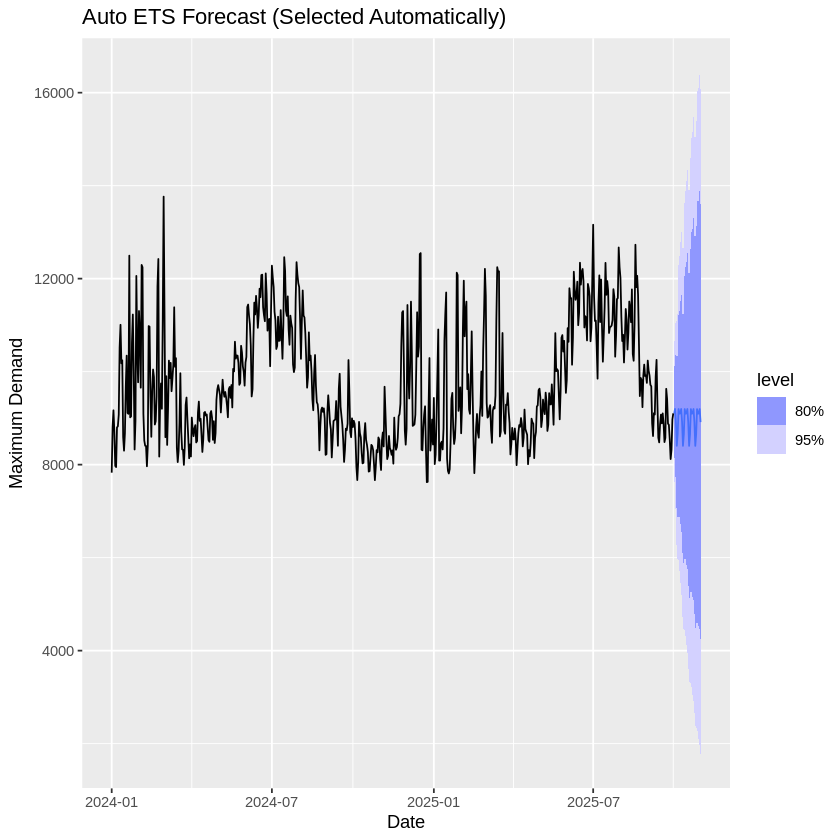

In [15]:
# Fit Auto ETS Model

ets_auto <- train_data %>%
  model(ETS(MaxDemand))

report(ets_auto)

ets_auto_fc <- forecast(ets_auto, h = nrow(test_data))

autoplot(ets_auto_fc, train_data) +
  labs(
    title = "Auto ETS Forecast (Selected Automatically)",
    y = "Maximum Demand", x = "Date"
  )


In [16]:
# Compare Results

ets_accuracy_results <- bind_rows(
  accuracy(ets_manual_fc, test_data),
  accuracy(ets_auto_fc, test_data),
  .id = "Model"
)

ets_accuracy_results

Model,.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,"ETS(MaxDemand ~ error(""M"") + trend(""A"") + season(""M""))",Test,-31.79808,686.1925,443.6372,-0.9631127,4.966928,NaN,NaN,0.09787900
2,ETS(MaxDemand),Test,-297.36381,750.4297,575.4585,-4.0728520,6.677757,NaN,NaN,0.07838189


Series: MaxDemand 
Model: TSLM 

Residuals:
    Min      1Q  Median      3Q     Max 
-2345.9  -942.2  -315.2   964.6  3758.2 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.018e+04  1.841e+02  55.288  < 2e-16 ***
trend()       -3.255e+00  1.029e+00  -3.163  0.00164 ** 
I(trend()^2)   6.415e-03  1.557e-03   4.120 4.29e-05 ***
season()week2 -2.687e+02  1.776e+02  -1.513  0.13078    
season()week3 -8.158e+02  1.776e+02  -4.594 5.25e-06 ***
season()week4 -5.427e+02  1.776e+02  -3.056  0.00234 ** 
season()week5 -1.134e+00  1.771e+02  -0.006  0.99489    
season()week6 -9.740e+01  1.771e+02  -0.550  0.58254    
season()week7 -1.092e+02  1.776e+02  -0.615  0.53868    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1198 on 630 degrees of freedom
Multiple R-squared: 0.09274,	Adjusted R-squared: 0.08122
F-statistic:  8.05 on 8 and 630 DF, p-value: 2.2575e-10


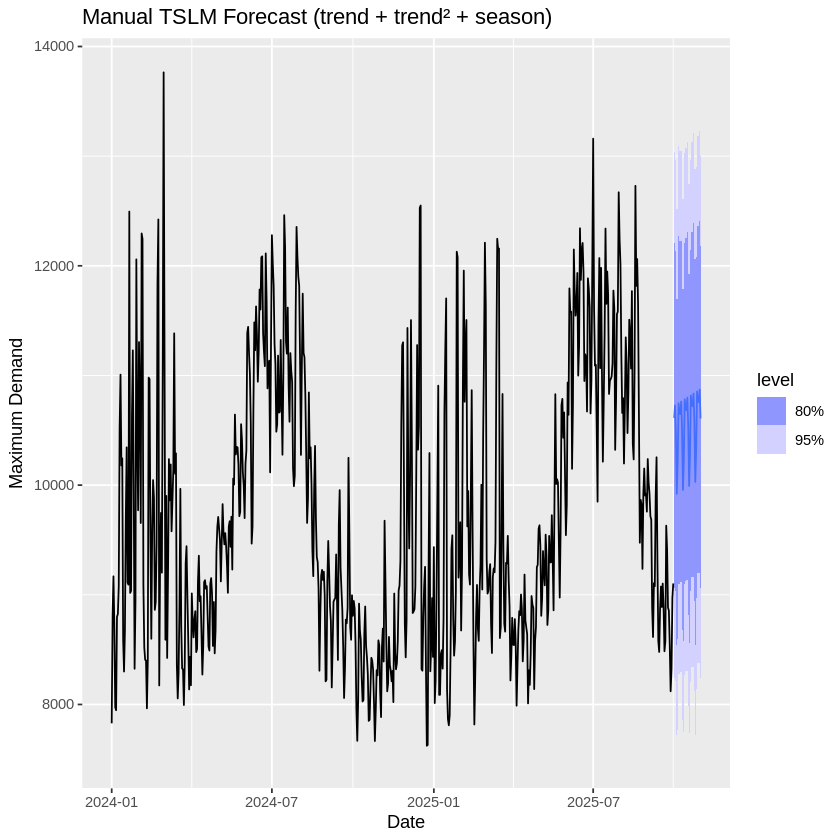

In [17]:
# Fit Manual TSLM Model

tslm_manual <- train_data %>%
  model(TSLM(MaxDemand ~ trend() + I(trend()^2) + season()))

report(tslm_manual)

tslm_manual_fc <- forecast(tslm_manual, h = nrow(test_data))

autoplot(tslm_manual_fc, train_data) +
  labs(
    title = "Manual TSLM Forecast (trend + trend² + season)",
    y = "Maximum Demand", x = "Date"
  )


Series: MaxDemand 
Model: TSLM 

Residuals:
    Min      1Q  Median      3Q     Max 
-2327.3  -970.2  -286.0  1029.9  3975.0 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9737.9366   151.8291  64.137  < 2e-16 ***
trend()          0.8504     0.2601   3.269  0.00114 ** 
season()week2 -268.6857   179.8141  -1.494  0.13561    
season()week3 -815.8165   179.8147  -4.537 6.83e-06 ***
season()week4 -542.6730   179.8156  -3.018  0.00265 ** 
season()week5    3.6550   179.3247   0.020  0.98375    
season()week6  -92.6108   179.3251  -0.516  0.60573    
season()week7 -109.2198   179.8141  -0.607  0.54380    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1213 on 631 degrees of freedom
Multiple R-squared: 0.06829,	Adjusted R-squared: 0.05796
F-statistic: 6.607 on 7 and 631 DF, p-value: 1.489e-07


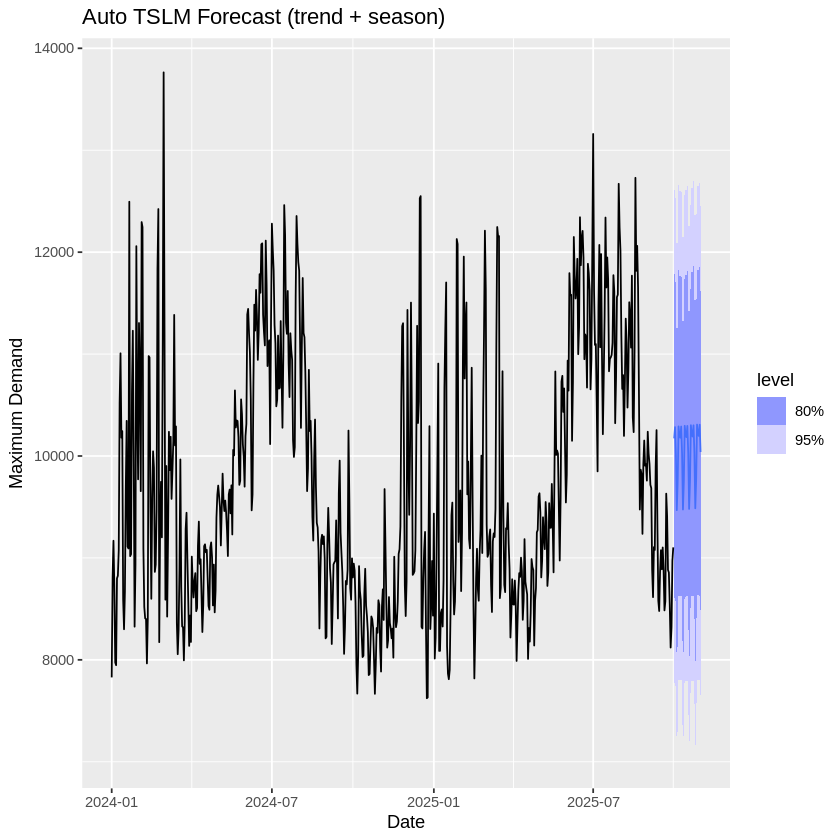

In [18]:
# Fit Auto TSLM Model

tslm_auto <- train_data %>%
  model(TSLM(MaxDemand ~ trend() + season()))

report(tslm_auto)

tslm_auto_fc <- forecast(tslm_auto, h = nrow(test_data))

autoplot(tslm_auto_fc, train_data) +
  labs(
    title = "Auto TSLM Forecast (trend + season)",
    y = "Maximum Demand", x = "Date"
  )


In [19]:
# Compare Results

tslm_accuracy_results <- bind_rows(
  accuracy(tslm_manual_fc, test_data),
  accuracy(tslm_auto_fc, test_data),
  .id = "Model"
)

tslm_accuracy_results

Model,.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,TSLM(MaxDemand ~ trend() + I(trend()^2) + season()),Test,-1896.603,2020.106,1923.683,-22.69683,22.93992,NaN,NaN,0.07647750
2,TSLM(MaxDemand ~ trend() + season()),Test,-1394.280,1556.535,1487.384,-16.84493,17.68982,NaN,NaN,0.07468156


In [20]:
# Convert the notebook to HTML using the system command
system("jupyter nbconvert --to html /content/MaximumDemand.ipynb")

In [21]:
#Discussion 4.1: Transformations and Time Series Cross-Validation

Warning message:
“`gg_tsdisplay()` was deprecated in feasts 0.4.2.
ℹ Please use `ggtime::gg_tsdisplay()` instead.”


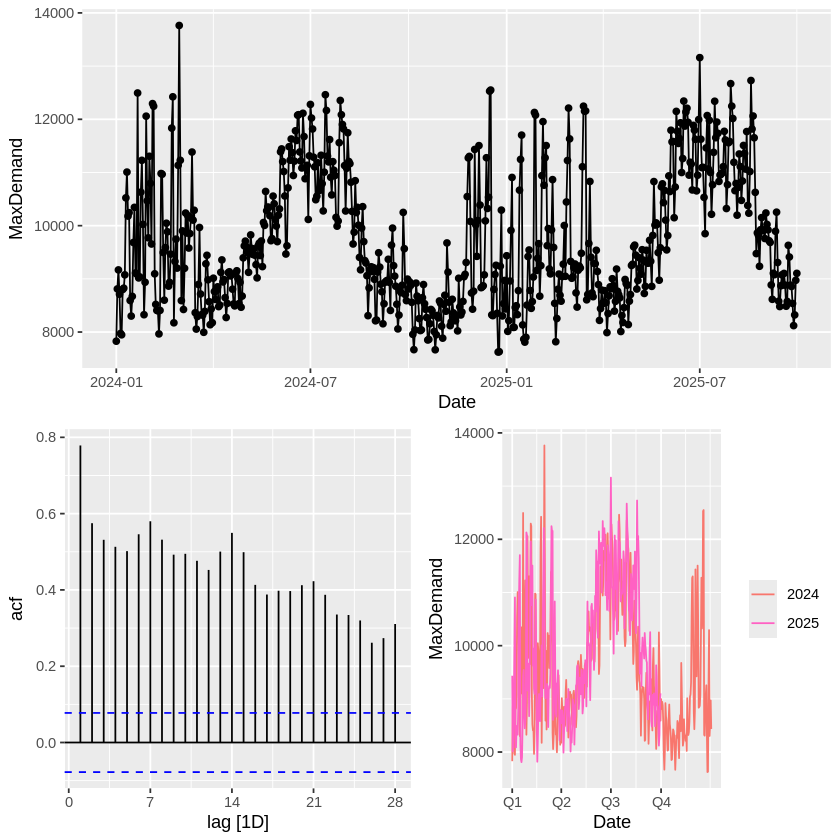

In [22]:
#STATIONARITY AND DIAGNOSTICS
# Visual check for patterns
train_data %>% gg_tsdisplay(MaxDemand)

In [23]:
#Statistical tests for stationarity
train_data %>%
  features(MaxDemand, c(unitroot_kpss, unitroot_ndiffs, unitroot_nsdiffs))


kpss_stat,kpss_pvalue,ndiffs,nsdiffs
<dbl>,<dbl>,<int>,<int>
0.5937108,0.02320811,1,0


In [24]:
#Check for heteroscedasticity and skewness

In [25]:
train_data %>%
  features(MaxDemand, feat_stl)

trend_strength,seasonal_strength_week,seasonal_peak_week,seasonal_trough_week,spikiness,linearity,curvature,stl_e_acf1,stl_e_acf10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7970049,0.3857624,1,6,1033589,3967.685,4952.131,0.2394583,0.3645754


In [26]:
# Best model from Week 3: ETS(M,A,M)
# Manual ETS(M,A,M) model with multiplicative error, additive trend, and multiplicative seasonality.

ets_manual <- train_data %>%
  model(ETS(MaxDemand ~ error("M") + trend("A") + season("M")))

report(ets_manual)

Series: MaxDemand 
Model: ETS(M,A,M) 
  Smoothing parameters:
    alpha = 0.5848713 
    beta  = 0.005340058 
    gamma = 0.0449898 

  Initial states:
     l[0]     b[0]     s[0]     s[-1]     s[-2]    s[-3]     s[-4]    s[-5]
 8601.718 155.5825 1.047225 0.9217148 0.9793855 1.006739 0.9741256 1.036788
    s[-6]
 1.034023

  sigma^2:  0.006

     AIC     AICc      BIC 
12606.67 12607.17 12660.19 


Warning message:
“`gg_tsresiduals()` was deprecated in feasts 0.4.2.
ℹ Please use `ggtime::gg_tsresiduals()` instead.”


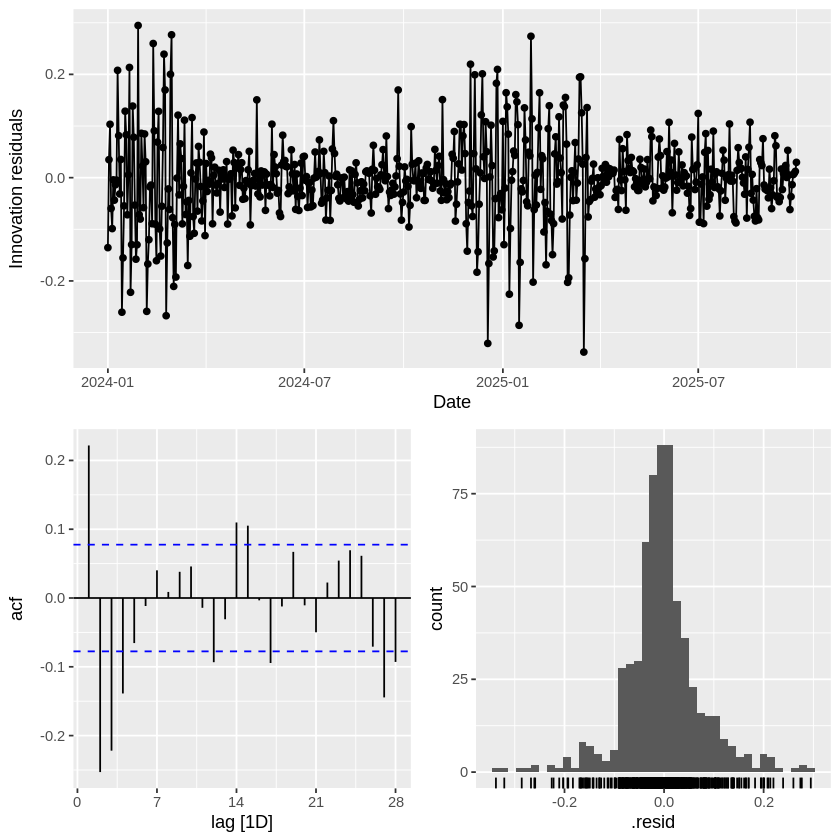

In [27]:
ets_manual %>%
  gg_tsresiduals(type = "innovation")

In [28]:
#Ljung-Box test for white noise
ets_manual %>%
  augment() %>%
  features(.innov, ljung_box, lag = 14)

.model,lb_stat,lb_pvalue
<chr>,<dbl>,<dbl>
"ETS(MaxDemand ~ error(""M"") + trend(""A"") + season(""M""))",137.4879,0


In [29]:
#Applying Transformations
lambda_guerrero <- guerrero(train_data$MaxDemand)
print(paste("Guerrero lambda:", lambda_guerrero))

[1] "Guerrero lambda: -0.899926773224204"


In [30]:
cat("\nOptimal Box-Cox lambda (Guerrero):", round(lambda_guerrero, 3), "\n")


Optimal Box-Cox lambda (Guerrero): -0.9 


In [31]:
#Refit the model on Box-Cox transformed data
lambda <- guerrero(train_data$MaxDemand)
train_transformed <- train_data %>%
  mutate(MaxDemand_BC = box_cox(MaxDemand, lambda))

ets_transformed <- train_transformed %>%
  model(ETS(MaxDemand_BC ~ error("M") + trend("A") + season("M")))

In [32]:
report(ets_transformed)

Series: MaxDemand_BC 
Model: ETS(M,A,M) 
  Smoothing parameters:
    alpha = 0.1727601 
    beta  = 0.0002445236 
    gamma = 0.04277281 

  Initial states:
     l[0]          b[0]     s[0]     s[-1]     s[-2]    s[-3]    s[-4]
 1.110887 -1.794874e-08 1.000002 0.9999883 0.9999989 1.000006 1.000001
     s[-5]    s[-6]
 0.9999975 1.000006

  sigma^2:  0

      AIC      AICc       BIC 
-9645.112 -9644.613 -9591.593 


In [33]:
fc_transformed <- forecast(ets_transformed, h = nrow(test_data))


In [34]:
#Back-transform to original scale
fc_back <- inv_box_cox(fc_transformed$.mean, lambda)

In [35]:
#Accuracy
tibble(
  Model = c("Original", "Transformed"),
  RMSE = c(
    sqrt(mean((ets_manual_fc$.mean - test_data$MaxDemand)^2)),
    sqrt(mean((fc_back - test_data$MaxDemand)^2))
  ),
  MAE = c(
    mean(abs(ets_manual_fc$.mean - test_data$MaxDemand)),
    mean(abs(fc_back - test_data$MaxDemand))
  )
)

Model,RMSE,MAE
<chr>,<dbl>,<dbl>
Original,686.1925,443.6372
Transformed,709.6965,492.5329


In [36]:
fc_back_tsibble <- test_data %>%
  mutate(Transformed_Forecast = inv_box_cox(fc_transformed$.mean, lambda))

Plot variable not specified, automatically selected `.vars = MaxDemand`
Plot variable not specified, automatically selected `.vars = MaxDemand`


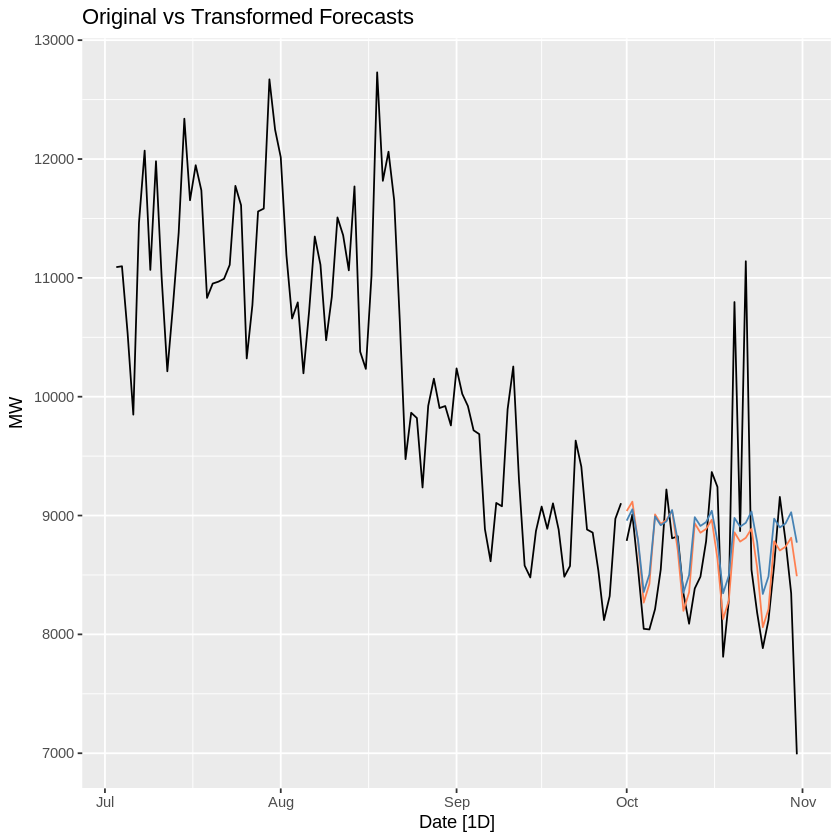

In [37]:
autoplot(train_data %>% tail(90)) +
  autolayer(test_data, color = "black") +
  autolayer(ets_manual_fc, level = NULL, color = "coral") +
  autolayer(fc_back_tsibble, Transformed_Forecast, color = "steelblue") +
  labs(title = "Original vs Transformed Forecasts", y = "MW")

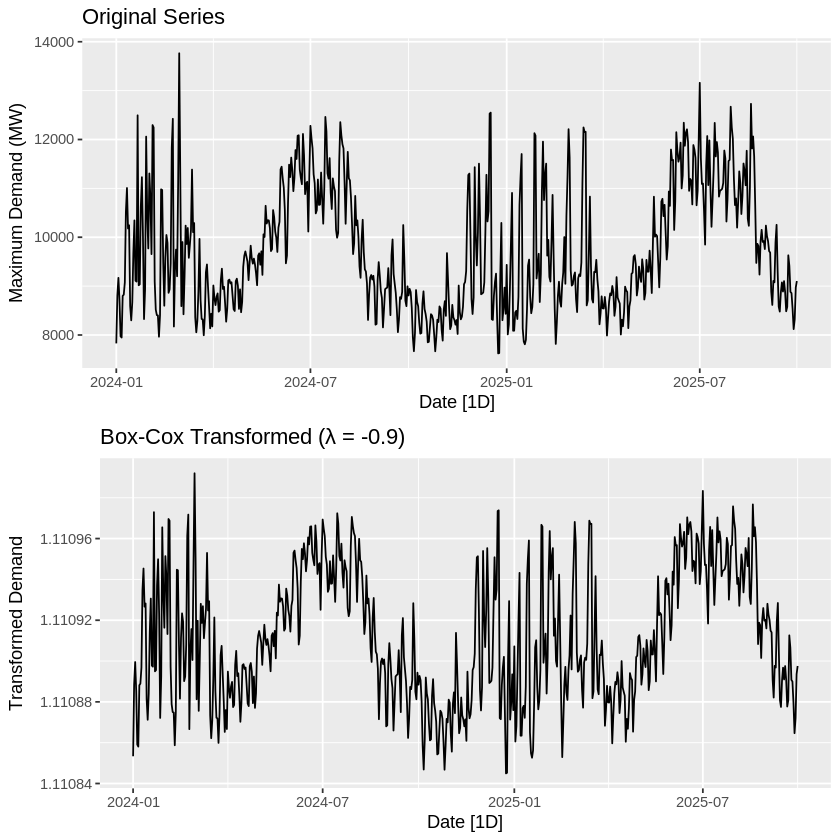

In [38]:
# Visualize original vs transformed series
p1 <- train_data %>%
  autoplot(MaxDemand) +
  labs(title = "Original Series", y = "Maximum Demand (MW)")

p2 <- train_data %>%
  mutate(MaxDemand_BC = box_cox(MaxDemand, lambda_guerrero)) %>%
  autoplot(MaxDemand_BC) +
  labs(title = paste0("Box-Cox Transformed (λ = ", round(lambda_guerrero, 3), ")"),
       y = "Transformed Demand")

gridExtra::grid.arrange(p1, p2, ncol = 1)

In [39]:
# Fit ARIMA on transformed data
arima_trans_manual <- train_transformed %>%
  model(ARIMA(MaxDemand_BC ~ pdq(0,1,1) + PDQ(0,1,1)))

report(arima_trans_manual)

arima_trans_auto <- train_transformed %>%
  model(ARIMA(MaxDemand_BC))

report(arima_trans_auto)

Series: MaxDemand_BC 
Model: ARIMA(0,1,1)(0,1,1)[7] 

Coefficients:
          ma1     sma1
      -0.1213  -0.9996
s.e.   0.0742   0.0195

sigma^2 estimated as 1.605e-08:  log likelihood=5952.25
AIC=-11898.5   AICc=-11898.46   BIC=-11885.16
Series: MaxDemand_BC 
Model: ARIMA(1,1,2)(0,0,2)[7] 

Coefficients:
         ar1      ma1      ma2    sma1    sma2
      0.2394  -0.4333  -0.4169  0.1511  0.2041
s.e.  0.0717   0.0661   0.0494  0.0400  0.0407

sigma^2 estimated as 2.264e-09:  log likelihood=6076.16
AIC=-12140.31   AICc=-12140.18   BIC=-12113.56


In [43]:
library(purrr)
library(distributional)

# Forecast the BC ARIMA model
fc_trans_manual <- forecast(arima_trans_manual, h = nrow(test_data))

# Convert to tibble to avoid fable internal rebuild errors
fc_tib <- fc_trans_manual %>% as_tibble()

# Back-transform BC forecast and compute quantile intervals
fc_bt_manual <- fc_tib %>%
  mutate(
    mean_bt    = forecast::InvBoxCox(.mean, lambda),

    lower80_bt = forecast::InvBoxCox(map_dbl(MaxDemand_BC, ~ quantile(.x, 0.10)), lambda),
    upper80_bt = forecast::InvBoxCox(map_dbl(MaxDemand_BC, ~ quantile(.x, 0.90)), lambda),

    lower90_bt = forecast::InvBoxCox(map_dbl(MaxDemand_BC, ~ quantile(.x, 0.05)), lambda),
    upper90_bt = forecast::InvBoxCox(map_dbl(MaxDemand_BC, ~ quantile(.x, 0.95)), lambda)
  )

# Replace missing ribbon values
fc_bt_manual <- fc_bt_manual %>%
  mutate(
    lower80_bt = ifelse(is.na(lower80_bt), mean_bt, lower80_bt),
    upper80_bt = ifelse(is.na(upper80_bt), mean_bt, upper80_bt),
    lower90_bt = ifelse(is.na(lower90_bt), mean_bt, lower90_bt),
    upper90_bt = ifelse(is.na(upper90_bt), mean_bt, upper90_bt)
  )

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



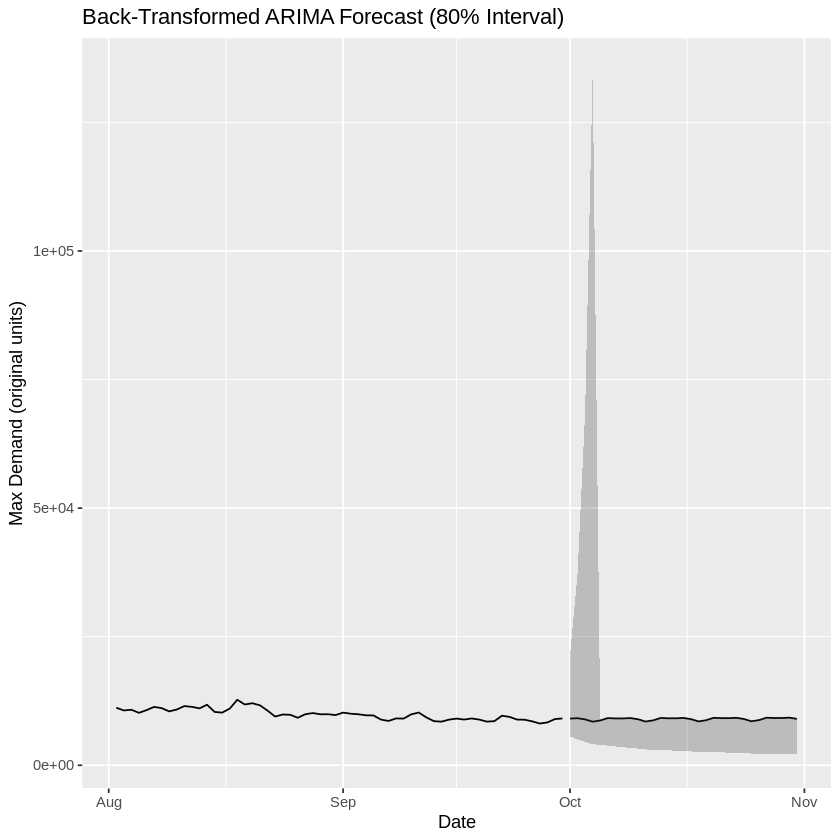

In [45]:
ggplot() +
  geom_line(data = train_data %>% tail(60),
            aes(Date, MaxDemand)) +
  geom_line(data = fc_bt_manual,
            aes(Date, mean_bt)) +
  geom_ribbon(
    data = fc_bt_manual,
    aes(Date, ymin = lower80_bt, ymax = upper80_bt),
    alpha = 0.25
  ) +
  labs(
    title = "Back-Transformed ARIMA Forecast (80% Interval)",
    x = "Date",
    y = "Max Demand (original units)"
  )